<a href="https://colab.research.google.com/github/Hongyu-Zhuo/colab-demo/blob/main/Z_Image_Turbo_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/comfyanonymous/ComfyUI

%cd /content/ComfyUI
!pip install -r requirements.txt

!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/T5B/Z-Image-Turbo-FP8/resolve/main/z-image-turbo-fp8-e4m3fn.safetensors -d /content/ComfyUI/models/diffusion_models -o z-image-turbo-fp8-e4m3fn.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/z_image_turbo/resolve/main/split_files/text_encoders/qwen_3_4b.safetensors -d /content/ComfyUI/models/clip -o qwen_3_4b.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/z_image_turbo/resolve/main/split_files/vae/ae.safetensors -d /content/ComfyUI/models/vae -o ae.safetensors

Cloning into 'ComfyUI'...
remote: Enumerating objects: 28887, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 28887 (delta 3), reused 3 (delta 3), pack-reused 28881 (from 2)
Receiving objects: 100% (28887/28887), 75.33 MiB | 9.61 MiB/s, done.
Resolving deltas: 100% (19592/19592), done.
/content/ComfyUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 18.0 MB/s eta 0:00:00
  

In [2]:
%cd /content/ComfyUI

import os, random, time

import torch
import numpy as np
from PIL import Image

from nodes import NODE_CLASS_MAPPINGS

UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
CLIPLoader = NODE_CLASS_MAPPINGS["CLIPLoader"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
CLIPTextEncode = NODE_CLASS_MAPPINGS["CLIPTextEncode"]()
KSampler = NODE_CLASS_MAPPINGS["KSampler"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    unet = UNETLoader.load_unet("z-image-turbo-fp8-e4m3fn.safetensors", "fp8_e4m3fn_fast")[0]
    clip = CLIPLoader.load_clip("qwen_3_4b.safetensors", type="lumina2")[0]
    vae = VAELoader.load_vae("ae.safetensors")[0]

@torch.inference_mode()
def generate(input):
    tmp_dir="/content/ComfyUI/output"
    os.makedirs(tmp_dir, exist_ok=True)

    values = input["input"]

    positive_prompt = values['positive_prompt']
    negative_prompt = values['negative_prompt']
    seed = values['seed'] # 0
    steps = values['steps'] # 9
    cfg = values['cfg'] # 1.0
    sampler_name = values['sampler_name'] # euler
    scheduler = values['scheduler'] # simple
    denoise = values['denoise'] # 1.0
    width = values['width'] # 1024
    height = values['height'] # 1024
    batch_size = values['batch_size'] # 1.0

    if seed == 0:
        random.seed(int(time.time()))
        seed = random.randint(0, 18446744073709551615)

    positive = CLIPTextEncode.encode(clip, positive_prompt)[0]
    negative = CLIPTextEncode.encode(clip, negative_prompt)[0]
    latent_image = EmptyLatentImage.generate(width, height, batch_size=batch_size)[0]
    samples = KSampler.sample(unet, seed, steps, cfg, sampler_name, scheduler, positive, negative, latent_image, denoise=denoise)[0]
    decoded = VAEDecode.decode(vae, samples)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save(f"{tmp_dir}/z_image_turbo.png")

    result = f"{tmp_dir}/z_image_turbo.png"

    return result

/content/ComfyUI


  0%|          | 0/9 [00:00<?, ?it/s]

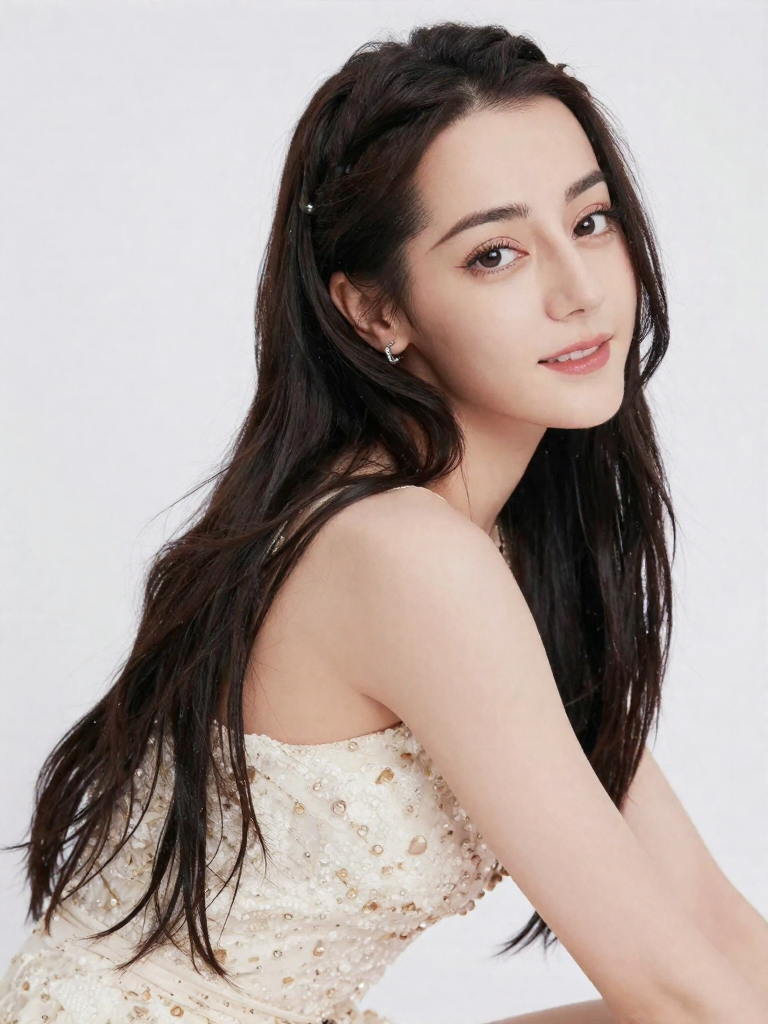

In [8]:
input = {
  "input": {
    "positive_prompt": """
      迪丽热巴,
    """,
    "negative_prompt": "blurry ugly bad",
    "width": 768,
    "height": 1024,
    "batch_size": 1,
    "seed": 0,
    "steps": 9,
    "cfg": 1,
    "sampler_name": "euler",
    "scheduler": "simple",
    "denoise": 1.0,
  }
}

output = generate(input)
Image.open(output)